**k-means問題**はクラスタリングに関する問題で、データの集合を$X$、クラスタ数を$k$とした時に、$X$の[分割](https://ja.wikipedia.org/wiki/%E9%9B%86%E5%90%88%E3%81%AE%E5%88%86%E5%89%B2)$S = \{S_1, S_2, \dots, S_k\}$ の中で以下のコスト関数

$$
\underset{S}{\arg\min} \sum_{i=1}^k\sum_{x\in S_i}\|x-\mu_i\|^2
$$

を最小にするものを見つけることが目的です。

ここで $\mu_i$ はクラスタの中心で

$$
\mu_i = \frac{1}{|S_i|}\sum_{x\in S_i}x
$$

と平均値で計算されることが多いです。

# k-means法

この問題は**NP困難**であることが知られていますが、[k-means法](https://ja.wikipedia.org/wiki/K%E5%B9%B3%E5%9D%87%E6%B3%95)（[Lloydアルゴリズム](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm)）と呼ばれる**局所解を高速に与える有名なアルゴリズム**があります。それは以下のようなものです。

1. クラスタの中心としてデータ点からランダムにk個を選ぶ
2. 各データ点を中心が最も近いクラスタに分類する
3. 各クラスタに属するデータから改めて中心を計算する
4. 収束するまで2,3を繰り返す

アルゴリズムのイメージは実際に視覚的に見てみるのが分かりやすいでしょう。以下のサイトがk-means法を可視化してくれていてインタラクティブに試すことができるのでオススメです。

- [K-means 法を D3.js でビジュアライズしてみた](http://tech.nitoyon.com/ja/blog/2013/11/07/k-means/)

Haskellにもk-means法を実装したライブラリはあります。

- [kmeans](https://hackage.haskell.org/package/kmeans-0.1.3)
- [kmeans-vector](https://hackage.haskell.org/package/kmeans-vector-0.3.2)
- [clustering](https://hackage.haskell.org/package/clustering)

ですが今回は自分で実装します。

In [1]:
{-# LANGUAGE BlockArguments, DataKinds #-} 

import GHC.TypeLits

import qualified Data.Vector.Sized as V


-- | ボロノイ分割
voronoiDecompose :: (KnownNat (n+1), Ord b)
                 => (a -> a -> b)       -- 距離関数
                 -> [a]                 -- データ点
                 -> V.Vector (n+1) a    -- 中心点
                 -> V.Vector (n+1) [a]  -- ボロノイ分割
voronoiDecompose distance ds cs =
  V.accum (flip (:)) (V.replicate []) $
    map (\d -> (V.minIndex $ V.map (distance d) cs, d)) ds


-- | k-means法
kMeans :: (KnownNat (n+1), Eq a, Ord b)
       => (a -> a -> b)     -- 距離関数
       -> ([a] -> a)        -- 集約関数
       -> [a]               -- データ点
       -> V.Vector (n+1) a  -- 中心点
       -> V.Vector (n+1) a  -- 中心点
kMeans distance aggregate ds cs =
  let cs' = V.map aggregate $ voronoiDecompose distance ds cs
   in if cs == cs' then cs' else kMeans distance aggregate ds cs'

`voronoiDecompose` は与えられた中心点に従ってデータ点を[ボロノイ領域](https://ja.wikipedia.org/wiki/%E3%83%9C%E3%83%AD%E3%83%8E%E3%82%A4%E5%9B%B3)で分類する関数です。データ点はリストとして扱っていますが、中心点はランダムアクセスしたいので [`Vector`](https://hackage.haskell.org/package/vector-sized-1.6.1/docs/Data-Vector-Sized.html#t:Vector) を使って $O(1)$ アクセスできるようにしています。データ点の型は型変数で抽象化しており、必要になる距離関数は後から与えられるようになっています。

`kMeans` はk-means法を計算する関数です。データ点をボロノイ分割した結果を集約して計算した新しい中心点がもとの中心点と一致するまで計算を繰り返します。

# k-means++法

`kMeans` は中心点を更新していく関数として実装していますがそもそもの中心点はどのように用意すれば良いでしょうか。もちろんランダムなデータ点を取ってきても良いのですが、[k-means++法](https://ja.wikipedia.org/wiki/K-means%2B%2B%E6%B3%95)と呼ばれる効率の良い中心点の与え方が知られています。k-means++法は以下のようなアルゴリズムです。

1. データ点からランダムに1つ目の中心点を選ぶ
2. それぞれのデータ点$x$に対して、最も近い中心点からの距離$D(x)$を計算する
3. データ点$x$につき重み$\frac{D^2(x)}{\sum_{x\in X}D^2(x)}$を考慮して新しい中心点をランダムに選ぶ
4. 選ばれた中心点の数が予め与えられたクラスタ数$k$に到達するまで2,3を繰り返す

感覚的には今ある中心点より遠くにあるデータ点が選ばれやすくなるように新しい中心点を選ぶような形になっています。それなら単純に$D(x)$に比例した重みでサンプリングしても良さそうなものですが、このアルゴリズムによって選ばれた中心点により評価したk-means問題のコスト関数の値を$\phi$とすると、コスト関数の最小値$\phi_{\rm OPT}$に対して

$$
{\rm E}[\phi] \leq 8(\log k+2)\phi_{\rm OPT}
$$

を満たすことが[証明できます](https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf)。この証明には**コーシー・シュワルツの不等式**が使われていて二乗の形であることが本質的な役割を果たしているのです（もう少し荒い評価にはなりますが単純に$l^p$距離を用いた場合の不等式も論文には載っています）。このようにk-means++法は初期の中心点を決めた時点で期待値における理論的な精度評価が得られていますが、更にその後k-means法を用いてコスト関数を単調減少させることにより良いクラスタリングの結果が得られるようになっているのです。

それではk-means++法を実装してみましょう。

In [2]:
import Data.Proxy (Proxy(..))

import qualified Data.Vector.Generic as VG
import qualified Data.Vector.Generic.Sized.Internal as VGSI
import Data.Random (randomElement, RVar)
import Data.Random.Distribution.Categorical (weightedCategorical)


-- ref. https://github.com/expipiplus1/vector-sized/issues/123
unfoldrM :: forall m n a b. (Monad m, KnownNat n)
         => (b -> m (a, b)) -> b -> m (V.Vector n a)
unfoldrM f z = VGSI.Vector <$> VG.unfoldrExactNM i f z
  where i = fromIntegral (natVal (Proxy :: Proxy n))


-- | k-means++法
kMeansPlusPlus :: KnownNat n
               => (a -> a -> Double)  -- 距離関数
               -> [a]                 -- データ点
               -> RVar (V.Vector n a) -- 中心点
kMeansPlusPlus distance ds = unfoldrM f []
  where
  f [] = do
    c <- randomElement ds
    pure (c, [c])
  f cs = do
    let ws = map (\d -> minimum $ map (\c -> distance c d ^2) cs) ds
    c <- weightedCategorical (zip ws ds)
    pure (c, c:cs)

k-means++法を実装するために`unfoldrM`という便利関数を定義しています。実は`vector`ライブラリにはこのような関数が[定義されている](https://hackage.haskell.org/package/vector-0.13.1.0/docs/Data-Vector-Unboxed.html#g:10)のですが`vector-sized`には無いので自前で実装しています（実装して欲しいという[issue](https://github.com/expipiplus1/vector-sized/issues/123)はあります）。

`unfoldrM`を使えばk-means++法は素直に場合分けして実装するだけです。k-means++法はランダムな選択を伴うので何らかのモナドに包む必要があります。`IO`にしてしまっても良いのですが[確率分布もまたそれ自体がモナドになる](https://qiita.com/lotz/items/7c7df718d1a596cac920)ので、できるだけ抽象的な型に留める形で実装しています。確率分布（確率変数）の型として、ここでは [`random-fu`](https://hackage.haskell.org/package/random-fu)の`RVar`を使っています。

# 実験
それでは実装したk-means法、k-means++法を使って実際にクラスタリングを行ってみましょう。まずはクラスタリングの対象となる平面上の点を実装していきます。

In [3]:
import Data.List (foldl')
import Data.Maybe (fromJust)


-- | 平面上の点
type Point = V.Vector 2 Double


-- | x, y 座標から点を構築する
mkPoint :: Double -> Double -> Point
mkPoint a b = fromJust $ V.fromList [a, b]


-- | 距離関数
distance :: Point -> Point -> Double
distance v1 v2 = sqrt . V.sum . V.map (^2) $ V.zipWith (-) v1 v2


-- | 平均値関数
average :: [Point] -> Point
average ps =
  let n = fromIntegral $ length ps
   in V.map (/n) $ foldl' (V.zipWith (+)) (V.replicate 0) ps

最後にこれらの点をランダムにサンプリングしてクラスタリングしてみましょう。クラスタの数は型に現れるので型注釈で与えます。

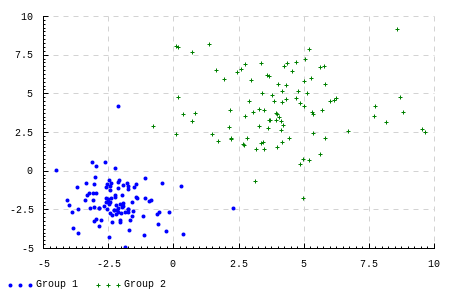

In [4]:
import Control.Monad (replicateM)
import Data.Traversable (forM)

import Data.Random (normal, sampleFrom)
import Graphics.Rendering.Chart.Easy
import System.Random.Stateful (newIOGenM, mkStdGen)


samples :: RVar [Point]
samples = concat <$> forM clusters \(m, s) ->
  replicateM nEachSamples $ mkPoint <$> normal m s <*> normal m s
  where
  nEachSamples = 100  
  clusters = [(-2, 1), (4, 2)]


do
  gen <- newIOGenM (mkStdGen 42)
  ds <- sampleFrom gen samples
  cs <- sampleFrom gen $
    kMeansPlusPlus distance ds :: IO (V.Vector 2 Point)  -- k-means++法
  let cs' = kMeans distance average ds cs  -- k-means法
      voronoi = voronoiDecompose distance ds cs'
      toTuple v = (V.index v 0, V.index v 1)
  pure $ toRenderable $ do
    plot (points "Group 1" . map toTuple $ V.index voronoi 0)
    plot (points "Group 2" . map toTuple $ V.index voronoi 1)